#Week 5 Assignment

RNN & LSTM (by imjjun KUBIG 16th)


---


Finally, we would handle some models related to NLP, which are RNN & LSTM ! These models are clearly different with CNN because they guarantee the 'Sequentiality' which is a important factor on Natural Language (Communication is not static).

On this notebook, we would implement many things but still important:

- RNN Step forward

- RNN forward

- LSTM Step forward

- LSTM forward

- (Optional) RNN Backward / LSTM Backward

All of above things are '**Vanilla** version of RNN & LSTM' so that we could refer to our lecture note and substitute formula on Code ! Good LUCK :)

In [1]:
#Run this code!
#Fundamental Methods(You might need these things!)
import numpy as np

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def affine_forward(x, w, b):
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    return dx, dw, db

def sigmoid(x):
    """A numerically stable version of the logistic sigmoid function."""
    pos_mask = x >= 0
    neg_mask = x < 0
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

##1. RNN Step Forward

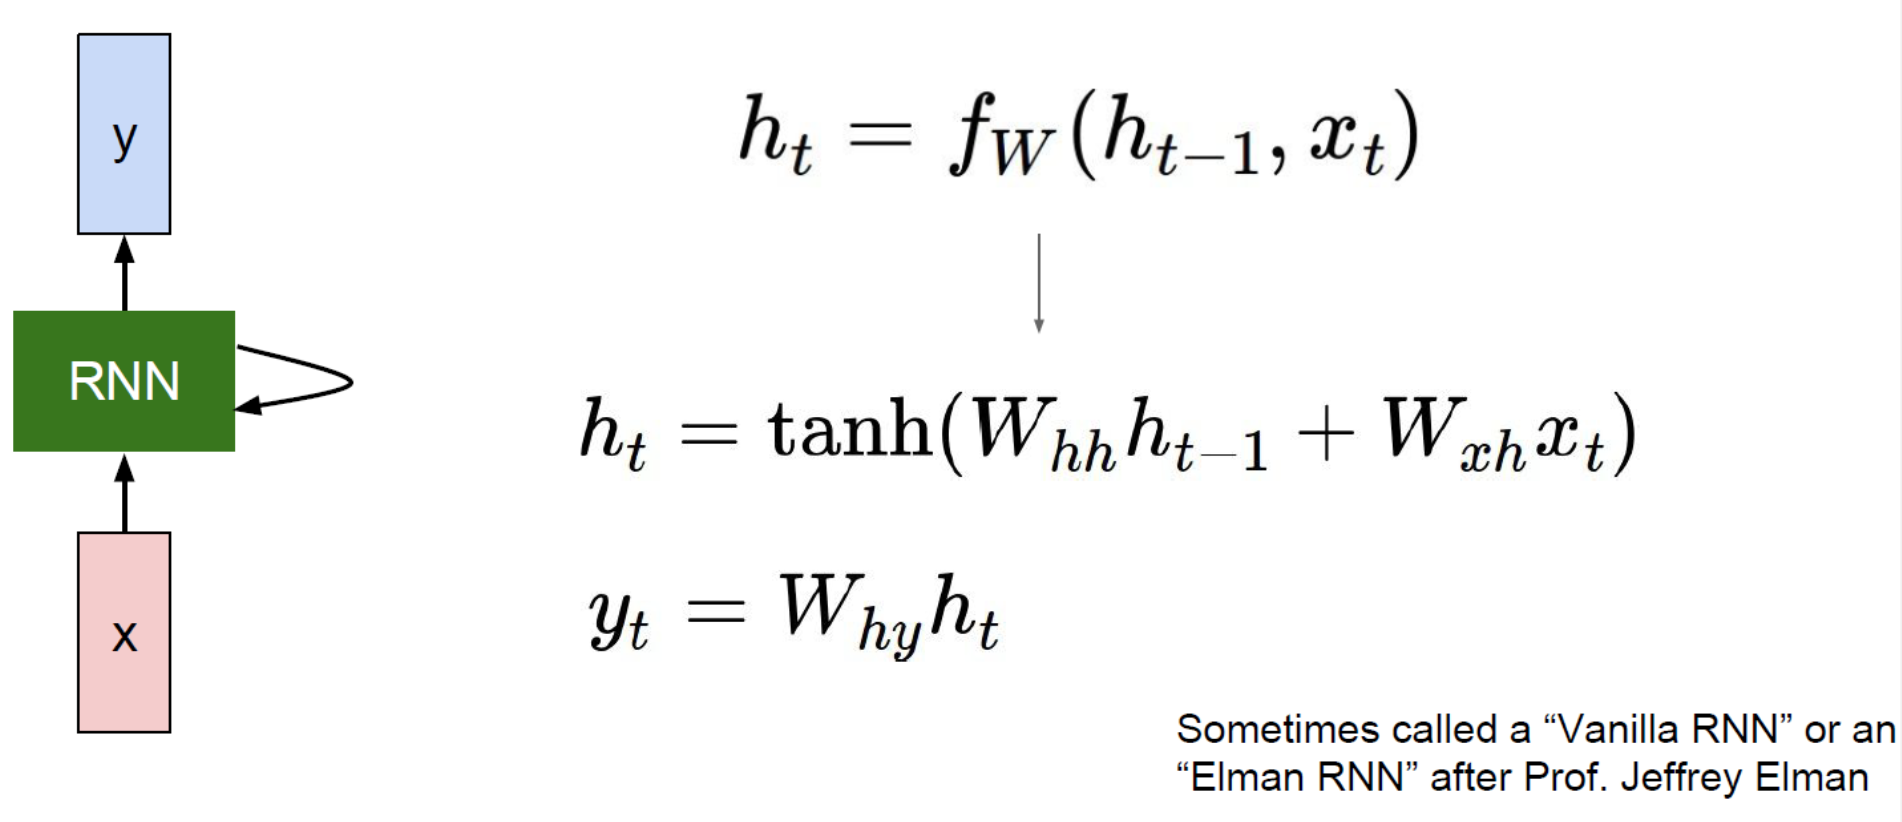

Reference: https://wikidocs.net/152774

Follow up the above formula which consists of the single timestep of RNN !

We could see the characteristic of 'Recurrent' by obtaining the variable hₜ

In [2]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """Run the forward pass for a single timestep of a vanilla RNN using a tanh activation function.

    The input data has dimension D, the hidden state has dimension H,
    and the minibatch is of size N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D)
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    # Hint: Sigmoid function had already been implemented.                       #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    next_h = np.tanh(np.dot(x, Wx) + np.dot(prev_h, Wh) + b)
    cache = (x, prev_h, Wx, Wh, next_h)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

We can check our implementation using this below test code.

In [3]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


##2. RNN Forward

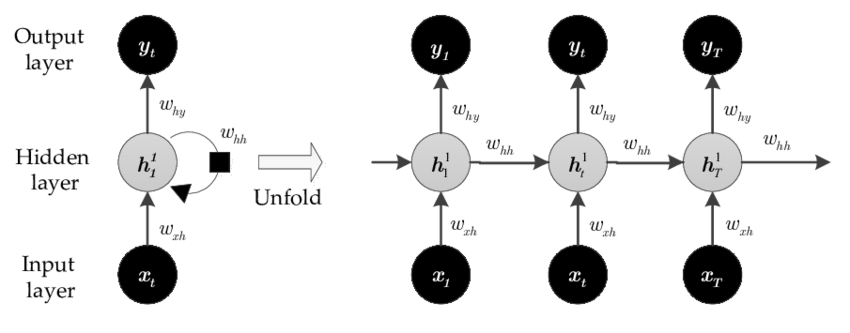

Reference: https://www.researchgate.net/figure/Recurrent-neural-network-RNN-The-circles-represent-network-layers-and-the-solid-lines_fig2_333119454

Actually, RNN is not a single time but "sequential' connection! It means that we have to connect whole cells through the time pass. We would implement this connection with the method 'rnn step forward' which had already been implemented above.

In [7]:
def rnn_forward(x, h0, Wx, Wh, b):
    """Run a vanilla RNN forward on an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the RNN forward,
    we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H)
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    h = np.zeros((x.shape[0], x.shape[1], h0.shape[1]))

    cache = [0 for _ in range(x.shape[1])]
    for t in range(x.shape[1]):
      next_h, cache_t = rnn_step_forward(x[:,t,:], h0, Wx, Wh, b)
      h0 = next_h
      h[:,t,:] = h0
      cache[t] = cache_t

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

Test Code

In [8]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


##3. LSTM Step Forward


At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

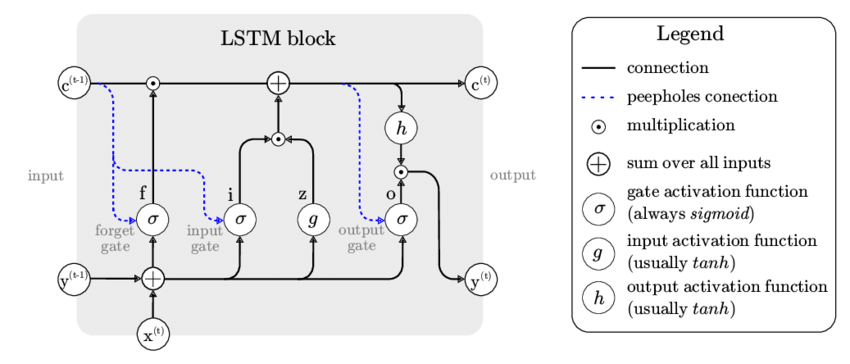

Reference: https://www.researchgate.net/figure/Architecture-of-a-typical-vanilla-LSTM-block_fig1_340493274

In [9]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Note that a sigmoid() function has already been provided for you in this file.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None
    #############################################################################
    # TODO: Implement the forward pass for a single timestep of an LSTM.        #
    # You may want to use the numerically stable sigmoid implementation above.  #
    # Hint: You have to carefully indice your variables!                        #
    # Consider the size of Inputs which parts are related to some operations.   #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    _, H = prev_c.shape
    score = np.dot(x, Wx) + np.dot(prev_h, Wh) + b
    i, f, o, g = score[:, :H], score[
        :, H:2 * H], score[:, 2 * H:3 * H], score[:, 3 * H:4 * H]
    i, f, o, g = sigmoid(i), sigmoid(f), sigmoid(o), np.tanh(g)
    next_c = np.multiply(f, prev_c) + np.multiply(i, g)
    next_h = np.multiply(o, np.tanh(next_c))
    cache = (x, prev_h, prev_c, Wx, Wh, b, i, f, o, g, next_c)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return next_h, next_c, cache

Test Code

In [10]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


##4. LSTM Forward

Similar implementation with RNN Forward, we would connect whole cells with the method 'LSTM Step Forward'.

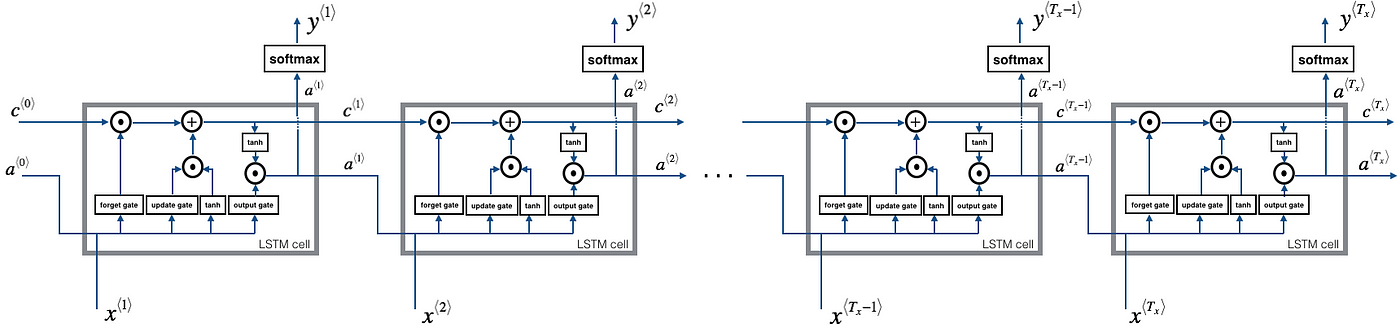

Reference: https://pub.towardsai.net/building-a-lstm-from-scratch-in-python-1dedd89de8fe?gi=b8be527fa1a2

In [15]:
def lstm_forward(x, h0, Wx, Wh, b):
    """Forward pass for an LSTM over an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the LSTM forward,
    we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell state is set to zero.
    Also note that the cell state is not returned; it is an internal variable to the LSTM and is not
    accessed from outside.

    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function that you just defined.      #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N, T, D = x.shape
    H = h0.shape[1]
    h = np.zeros((N, T, H))
    cache = []
    prev_h = h0
    prev_c = np.zeros((N, H))

    for ts in range(T):
      ts_x = x[:, ts, :]
      ts_h, ts_c, ts_cache = lstm_step_forward(ts_x, prev_h, prev_c, Wx, Wh, b)
      prev_h, prev_c = ts_h, ts_c.
      h[:, ts, :] = ts_h
      cache.append(ts_cache)



    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h, cache

Test Code

In [16]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537442272635e-08


##(Optional) 5. Backward Operations of RNN & LSTM


Optionally, we could implement a single timestep of LSTM & RNN quite simply.

RNN Step backward

In [19]:
def rnn_step_backward(dnext_h, cache):
    """Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a vanilla RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, prev_h, Wx, Wh, next_h = cache
    dout_dnext_h = dnext_h * (1 - np.power(next_h, 2))
    dx = dout_dnext_h.dot(Wx.T)
    dprev_h = dout_dnext_h.dot(Wh.T)
    dWx = x.T.dot(dout_dnext_h)
    dWh = prev_h.T.dot(dout_dnext_h)
    db = dout_dnext_h.sum(axis=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

Test code of RNN Step Backward

In [20]:
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.7795541640745535e-10
dprev_h error:  2.732467428030486e-10
dWx error:  9.709219069305414e-10
dWh error:  5.034262638717296e-10
db error:  1.708752322503098e-11


LSTM Step Backward

In [21]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    """Backward pass for a single timestep of an LSTM.

    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dprev_h, dprev_c, dWx, dWh, db = None, None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for a single timestep of an LSTM.       #
    #                                                                           #
    # HINT: For sigmoid and tanh you can compute local derivatives in terms of  #
    # the output value from the nonlinearity.                                   #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, prev_h, prev_c, Wx, Wh, b, i, f, o, g, next_c = cache
    tanh_nextc = np.tanh(next_c)
    one_minus_tanh_nextc_square = 1 - np.power(tanh_nextc, 2)
    dprev_c = np.multiply(dnext_c, f)
    dprev_c += np.multiply(np.multiply(o,np.multiply(one_minus_tanh_nextc_square, f)), dnext_h)

    d_i = np.multiply(dnext_c, g)
    d_i += np.multiply(np.multiply(o,np.multiply(one_minus_tanh_nextc_square, g)), dnext_h)
    d_f = np.multiply(dnext_c, prev_c)
    d_f += np.multiply(np.multiply(o,np.multiply(one_minus_tanh_nextc_square, prev_c)), dnext_h)
    d_o = np.multiply(dnext_h, tanh_nextc)
    d_g = np.multiply(dnext_c, i)
    d_g += np.multiply(np.multiply(o,np.multiply(one_minus_tanh_nextc_square, i)), dnext_h)

    d_i = np.multiply(d_i, i * (1 - i))
    d_f = np.multiply(d_f, f * (1 - f))
    d_o = np.multiply(d_o, o * (1 - o))
    d_g = np.multiply(d_g, 1 - np.power(g, 2))

    difog = np.hstack((d_i, d_f, d_o, d_g))

    dWh = np.dot(prev_h.T, difog)
    dWx = np.dot(x.T, difog)
    db = difog.sum(axis=0)

    dx = np.dot(difog, Wx.T)
    dprev_h = np.dot(difog, Wh.T)



    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dprev_h, dprev_c, dWx, dWh, db

LSTM Backward Test Code

In [22]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.833289135626099e-10
dh error:  3.416874560155995e-10
dc error:  1.5221795880129153e-10
dWx error:  1.6933643080684326e-09
dWh error:  2.7311400266248628e-08
db error:  1.7349356733443412e-10
